In [1]:
from IPython.display import HTML # type: ignore
import itertools
from pathlib import Path

import matplotlib.pyplot as plt
import more_itertools
import networkx as nx
import numpy as np
import numpy.linalg as la
from numpy.typing import NDArray
from tqdm.notebook import tqdm
import pandas as pd


import d3networkx as d3nx
from d3networkx.d3graph import D3DiGraph

from dcns.close_edges import with_close_edges
from dcns.graph_utils import node_attr_list_to_ndarray
from dcns.powerlaw import calc_powerlaw_multi
from dcns.plot_graphs import plot_graph, plot_pathfinding

In [2]:
G_time = D3DiGraph(nx.read_gml("data/dart_stops_time.gml"))
G_freq = D3DiGraph(nx.read_gml("data/dart_stops_freq.gml"))
# Unpack node pos from list to numpy array
node_attr_list_to_ndarray(G_time, "pos")
node_attr_list_to_ndarray(G_freq, "pos")
# G = D3DiGraph(nx.path_graph(5, create_using=nx.DiGraph))

pos = nx.get_node_attributes(G_time, "pos")

# Graph styles
style = {"node_size": 5}

In [3]:
import colorsys

def scale_lightness(rgb: tuple[float, float, float], scale_l: float):
    # convert rgb to hls
    h, l, s = colorsys.rgb_to_hls(*rgb)
    # manipulate h, l, s values and return as rgb
    return colorsys.hls_to_rgb(h, min(1, l * scale_l), s = s)

## Components

c:\Users\Andrew\Code\dcns-project\.venv\lib\site-packages\networkx\drawing\nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


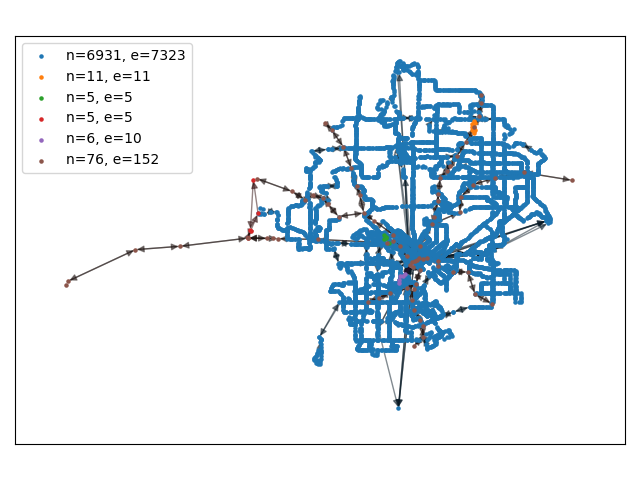

In [4]:
components = list(nx.weakly_connected_components(G_time))

fig, ax = plt.subplots()

# Plot each weakly-connected component in its own color
# nx.draw_networkx(G_time, pos=pos, with_labels=False)
colors = plt.get_cmap('tab10').colors # type: ignore

for component, color in zip(components, colors):
    G_comp = G_time.subgraph(component)
    # It is very dumb that we need to check the endpoints of the edges being in the
    # component's nodes, but for some reason, doing G.edges() on the subgraph yields no
    # edges, so this is the only way.
    edges = [
        (u, v) for u, v in G_time.edges()
        if np.linalg.norm(pos[u] - pos[v]) > 0.01
        and u in G_comp.nodes and v in G_comp.nodes
    ]
    nx.draw_networkx_edges(
        G_comp,
        pos=pos,
        ax=ax,
        edgelist=edges,
        edge_color=scale_lightness(color, 0.2), # type: ignore
        alpha=0.5,
        **style
    )
    nx.draw_networkx_nodes(
        G_comp,
        pos=pos,
        ax=ax,
        node_color=color,
        label=f"n={G_comp.number_of_nodes()}, e={G_comp.number_of_edges()}",
        **style
    )
ax.set_aspect("equal")

plt.legend()
fig.tight_layout()
fig.savefig("images/components.svg")

### Largest component and short edges

In [5]:
G2_time = G_time.__class__(G_time.subgraph(max(nx.strongly_connected_components(G_time), key=len)))
G2_freq = G_freq.__class__(G_freq.subgraph(max(nx.strongly_connected_components(G_freq), key=len)))

In [6]:
G3_time = with_close_edges(G2_time, 0.0007, weight=20)
G3_freq = with_close_edges(G2_freq, 0.0007, weight=1000)

100%|██████████| 2500/2500 [00:05<00:00, 479.38it/s]


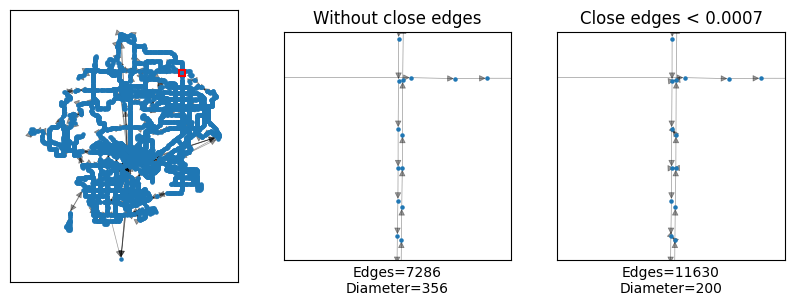

In [74]:
from matplotlib import patches
from dcns.graph_utils import crop_graph

bbox: NDArray[np.floating] = np.array([[-96.690, -96.675], [32.985, 33.0]])
offset_bbox = bbox + np.array([[-0.01, 0.01], [-0.01, 0.01]])

w, h = bbox[:, 1] - bbox[:, 0]
# G2_crop =

fig_close_edges, axes = plt.subplots(1, 3, squeeze=True, figsize=(10, 4))
fig_close_edges.tight_layout()

for ax in axes:
    ax.set_aspect("equal")

plot_graph(G2_freq, pos, axes[0], style=style)
axes[0].add_patch(
    patches.Rectangle(
        (bbox[0, 0], bbox[1, 0]),
        w,
        h,
        linewidth=1.5,
        edgecolor="r",
        facecolor="none",
        zorder=2,
    )
)

# Zoomed in, without close edges
plot_graph(crop_graph(G2_freq, pos, offset_bbox), pos, axes[1], min_edge_length=0, style=style, edges=G2_freq.edges())
axes[1].set_xlim(bbox[0,:])
axes[1].set_ylim(bbox[1,:])
axes[1].set_title("Without close edges")
axes[1].set_xlabel(f"Edges={G2_freq.number_of_edges()}\nDiameter={nx.diameter(G2_freq)}")

# Zoomed in with close edges
plot_graph(crop_graph(G3_freq, pos, offset_bbox), pos, axes[2], min_edge_length=0, style=style, edges=G3_freq.edges())
axes[2].set_xlim(bbox[0,:])
axes[2].set_ylim(bbox[1,:])
axes[2].set_title("Close edges < 0.0007")
axes[2].set_xlabel(f"Edges={G3_freq.number_of_edges()}\nDiameter={nx.diameter(G3_freq)}")

fig_close_edges.savefig("images/close_edges.svg")

plt.show()

## Powerlaw

100%|██████████| 2500/2500 [00:05<00:00, 484.58it/s]


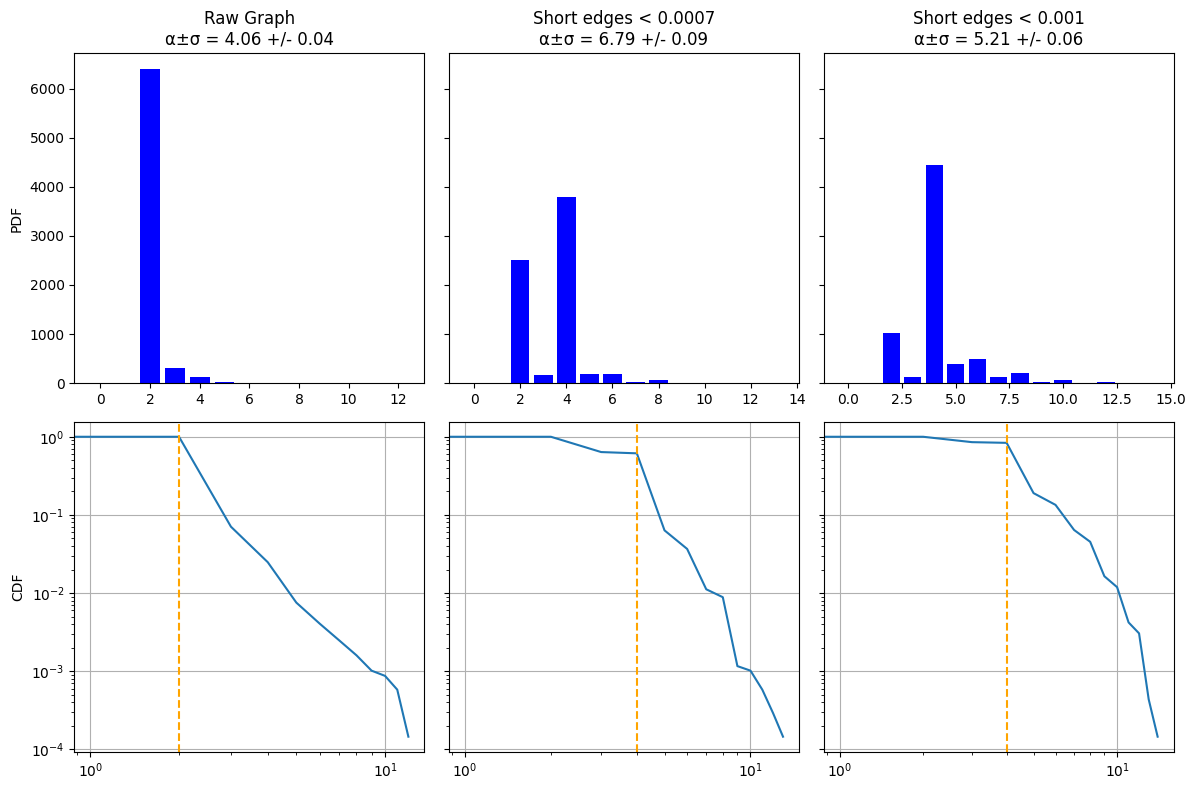

In [77]:
%matplotlib inline
fig_powerlaw = calc_powerlaw_multi(
    {
        "Raw Graph": (G2_freq, 2),
        "Short edges < 0.0007": (G3_freq, 4),
        "Short edges < 0.001": (with_close_edges(G2_freq, 0.001), 4),
    },
    sharey=True,
)
fig_powerlaw.tight_layout()
fig_powerlaw.savefig("images/powerlaw.svg")

## Pathfinding

In [9]:
from dcns.pathfinding import (
    dijkstra,
    astar,
    astar_search,
    pathfind_steps,
    astar_dist_search,
    astar_dist,
)


goals = [
    ("30141", "31212"),
    ("30140", "31212"),
    ("16516", "31212"),
    ("20527", "29291"),
    ("33302", "30496"),
    ("33286", "16971"),
]
# 30141 & 30140

start = goals[0][0]
end = goals[0][1]

len(astar(G2_time, start, end)[0])

117

### Close edges comparison

In [57]:
pos = nx.get_node_attributes(G2_time, "pos")
def path_stats(p, t, s):
    return {"path_len": len(p), "trip_time": t, "nodes_searched": s}

G2_df = pd.DataFrame(data=[
    path_stats(*astar_dist(G2_time, start, end, pos))
    for start, end in goals
])
G3_df = pd.DataFrame(data=[
    path_stats(*astar_dist(G3_time, start, end, pos))
    for start, end in goals
])

pd.concat([G2_df, G3_df], keys=["Trips only", "With close edges"], axis=1)

Trips only                          With close edges            \
    path_len trip_time nodes_searched         path_len trip_time   
0        117   5244.56           3891               32   2152.69   
1         78   4948.49           4237               31   2132.69   
2         62   3306.62           3176               16    633.14   
3         74   3983.81           1530               32   2077.99   
4         81   6841.49           3672               81   6841.49   
5         77   3255.68           3066               63   3046.16   

                  
  nodes_searched  
0           2010  
1           1984  
2             78  
3            669  
4           5007  
5           4190

Noteworthy observations
- Paths 0 and 1 were shortened significantly by adding the close edges. More so for path 0, which is on the opposite side of the street. The resultant path with the close edges for path 0 is one node longer than for path 1, which makes sense, as it is the same path after it crosses the street.
- Paths 2 and 3 are shortened significantly.
- Path 4 is the same path with and without the close edges, however, with the close edges results in searching more nodes.
- Path 5 is shorter, but also had to search more nodes.

### Algorithm comparison (6 nodes)

In [64]:
from functools import partial
from dcns.pathfinding import bfs, dijkstra, astar_dist

algorithms = {
    "bfs": bfs,
    "dijkstra": dijkstra,
    "a*-dist": partial(astar_dist, node_pos=pos),
}

pd.concat(
    [
        pd.DataFrame(
            data=[path_stats(*func(G2_time, start, end)) for start, end in goals]
        )
        for func in algorithms.values()
    ],
    keys=algorithms.keys(),
    axis=1,
)

bfs                          dijkstra                           \
  path_len trip_time nodes_searched path_len trip_time nodes_searched   
0      117   7317.49           4454      117   5244.56           3891   
1       78   6359.12           4454       78   4948.49           4237   
2       62   3306.62           3768       62   3306.62           3176   
3       74   4023.59           1497       74   3983.81           1531   
4       77   6981.51            514       81   6841.49           3672   
5       77   3385.24           4470       77   3255.68           3067   

   a*-dist                           
  path_len trip_time nodes_searched  
0      117   5244.56           3891  
1       78   4948.49           4237  
2       62   3306.62           3176  
3       74   3983.81           1530  
4       81   6841.49           3672  
5       77   3255.68           3066

### A* Heuristics Comparions

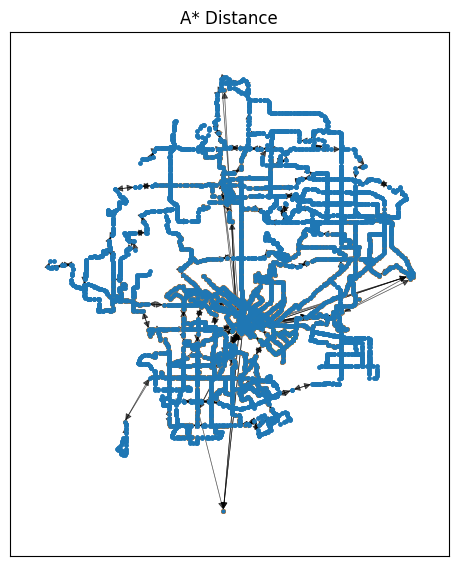

In [44]:
anim = plot_pathfinding(
    G2_time,
    astar_dist_search,
    goals[2][0],
    goals[2][1],
    min_edge_length=0.007,
    sample_steps=(200, 10),
    title="A* Distance",
    style=style,
)

anim.save("./images/astar_dist2.gif", writer="pillow", fps=10)

In [17]:
HTML(anim.to_jshtml())

  0%|          | 0/6 [00:00<?, ?it/s]

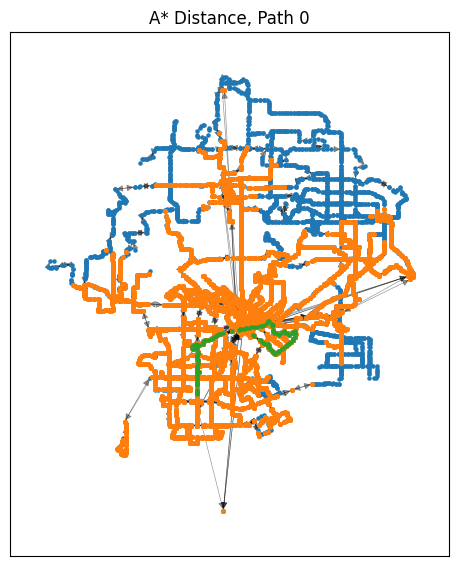

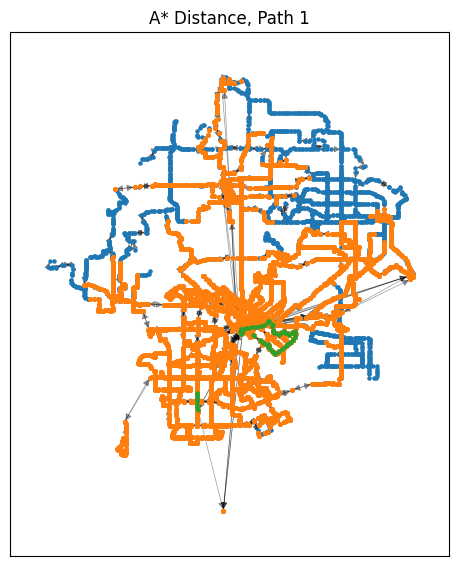

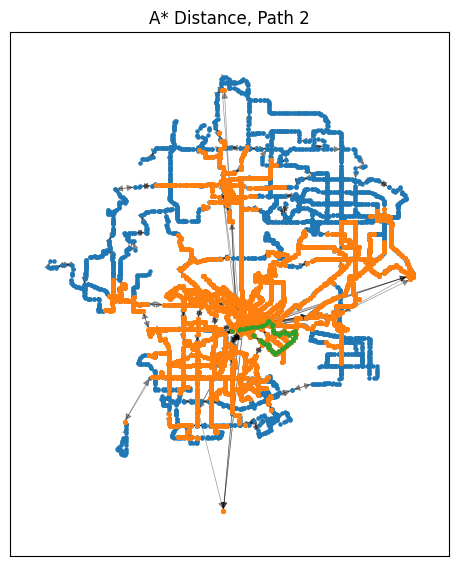

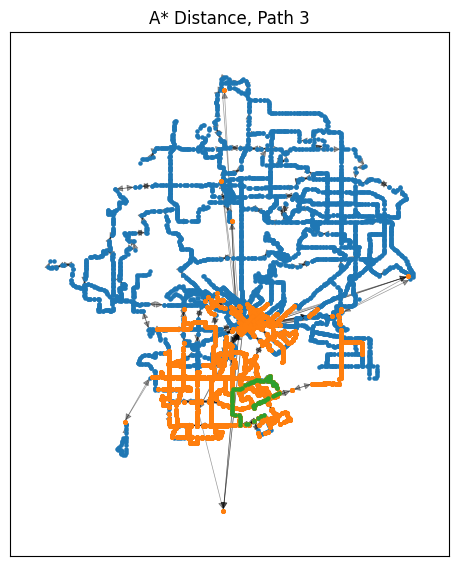

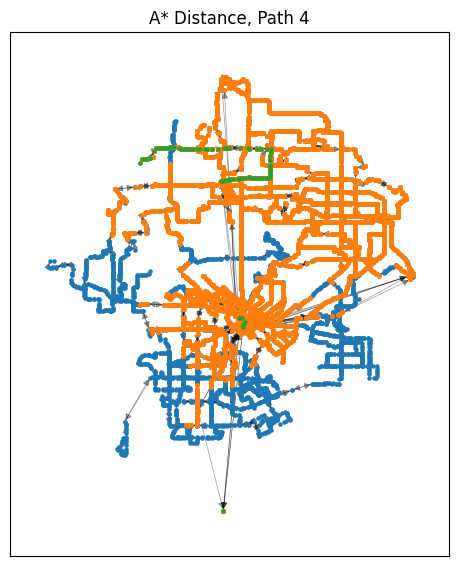

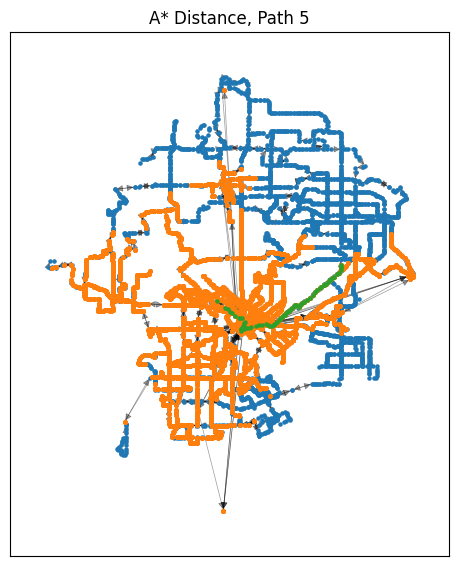

In [45]:
# Plot a* dist for each path
for i, (start, end) in tqdm(enumerate(goals), total=len(goals)):
    plot_pathfinding(
        G2_time,
        astar_dist_search,
        start,
        end,
        min_edge_length=0.007,
        sample_steps=(200, 10),
        title=f"A* Distance, Path {i}",
        style=style,
    ).save(f"./images/astar_dist{i}.gif", writer="pillow", fps=10)

  0%|          | 0/6 [00:00<?, ?it/s]

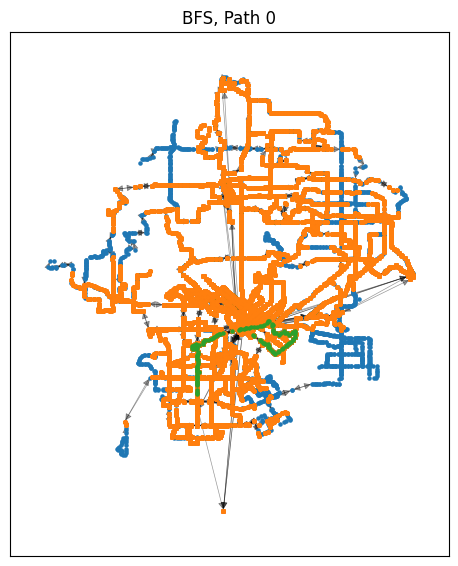

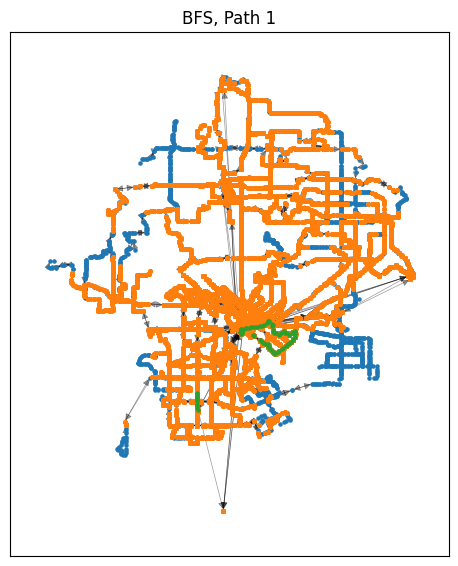

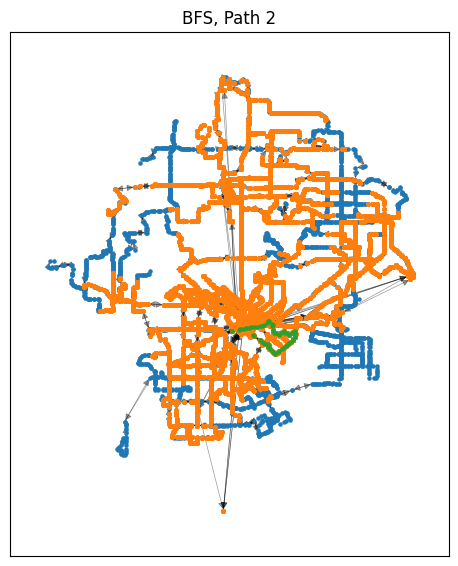

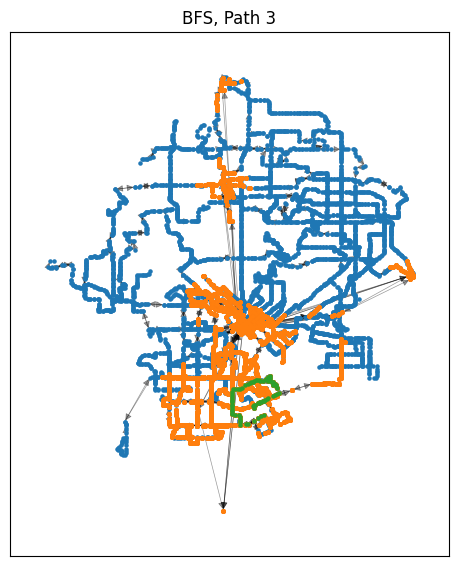

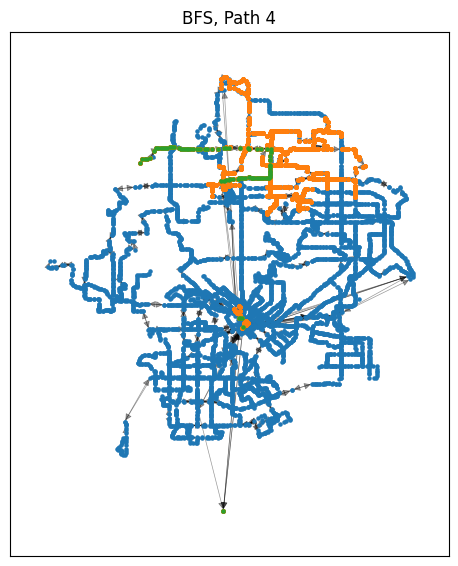

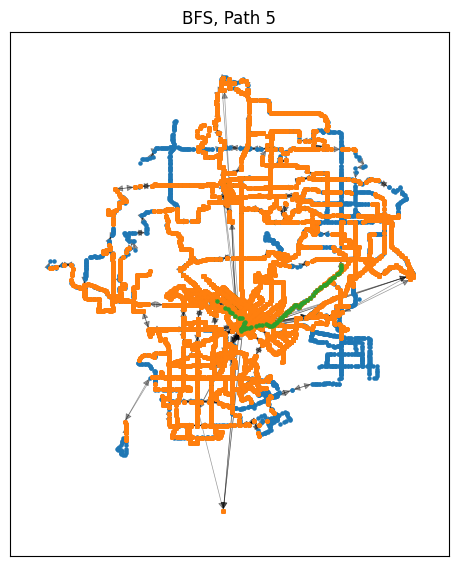

In [46]:
from dcns.pathfinding import bfs_search


for i, (start, end) in tqdm(enumerate(goals), total=len(goals)):
    plot_pathfinding(
        G2_time,
        bfs_search,
        start,
        end,
        min_edge_length=0.007,
        sample_steps=(200, 10),
        title=f"BFS, Path {i}",
        style=style,
    ).save(f"./images/bfs{i}.gif", writer="imagemagick", fps=10)

In [8]:
v = nx.katz_centrality(G2)
sorted(v.items(), key=lambda x: x[1], reverse=True)[:5]

[('20431', 0.024121808470581017),
 ('33245', 0.017330884066566143),
 ('33221', 0.01712656145339903),
 ('14071', 0.017077081909343667),
 ('33229', 0.016748426512332305)]

In [15]:
v = nx.eigenvector_centrality(G_freq)
sorted(v.items(), key=lambda x: x[1], reverse=True)[:5]

[('28264', 0.5368265196350608),
 ('22749', 0.4591515527756928),
 ('22748', 0.45889848812278444),
 ('28172', 0.2501210784473024),
 ('29825', 0.24689415583573063)]

In [67]:
nx.diameter(G2_time)
# Diameter = 356

200

In [85]:
import random

num_paths = 100

start_nodes = random.sample(list(G2_freq.nodes()), num_paths)
end_nodes = random.sample(list(G2_freq.nodes()), num_paths)

paths = list(zip(start_nodes, end_nodes))

In [141]:
from dcns.pathfinding import NoPathBetweenNodes

def coin_flip(G, p: float):
    _G = G.__class__()  # Clean copy
    _G.add_nodes_from(G)
    # Coin flip if edges will be included in new graph
    _G.add_edges_from(edge for edge in G.edges(data=True) if np.random.random() <= p)

    # Activated component(s) are those in the components that are initially activated
    return _G

def thing(G, start, end):
    try:
        return len(dijkstra(G, start, end)[0])
    except NoPathBetweenNodes:
        return None

dfp = []

for p in [1, 0.93, 0.87, 0.8]:
    G_test = coin_flip(G2_time, p)
    print(nx.is_strongly_connected(G_test))
    path_lengths = [thing(G_test, start, end) for start, end in tqdm(paths)]
    path_lengths = [x for x in path_lengths if x is not None]
    dfp.append(path_lengths)
    # Pathfinding on G_test

True


  0%|          | 0/100 [00:00<?, ?it/s]

False


  0%|          | 0/100 [00:00<?, ?it/s]

False


  0%|          | 0/100 [00:00<?, ?it/s]

False


  0%|          | 0/100 [00:00<?, ?it/s]

In [139]:
dfp[1].dropna()

,0,1
2,16.0,26.0
23,14.0,29.0
25,50.0,242.0
34,80.0,845.0
51,78.0,841.0
53,57.0,756.0
55,69.0,219.0


In [15]:
# Centrality
# G_freq is a directed graph and is what we will be analyzing in this section
# Functions
names = nx.get_node_attributes(G_freq, "name")
def sort_centrality(d: dict):
    return sorted({names[id]: np.round(v, 3) for id, v in d.items()}.items(), key=lambda x: x[1], reverse=True)

def get_centrality_df(G):
# Degree centrality
    return pd.DataFrame({
        "degree": sort_centrality({n: G.degree(n) for n in G.nodes()}),
        "eigenvector": sort_centrality(nx.eigenvector_centrality(G, tol=1e-3,weight='weight')),
        "katz": sort_centrality(nx.katz_centrality(G, 0.001,0.01,tol=1e-3,weight='weight')),
    })

get_centrality_df(G_freq).head()


,degree,eigenvector,katz
0,"(ELM @ HARWOOD - W - NS, 11)","(ELM @ LAMAR - W - NS, 0.49)","(ELM @ FIELD - W - FS, 0.077)"
1,"(SOUTH GARLAND TC, 11)","(ELM @ GRIFFIN - W - MB, 0.443)","(ELM @ GRIFFIN - W - MB, 0.076)"
2,"(ADDISON TRANSIT CENTER, 11)","(ELM @ FIELD - W - FS, 0.369)","(ELM @ LAMAR - W - NS, 0.073)"
3,"(LAKE RAY HUBBARD TRANSIT CENTER, 10)","(CBD WEST TC, 0.245)","(ELM @ AKARD - W - NS, 0.071)"
4,"(COCKRELL HILL TL, 9)","(ELM @ AUSTIN - W - NS, 0.241)","(COMMERCE @ LANE - E - NS, 0.067)"


In [70]:
# Betweenness centrality
# Highly related to percolation
# 3 MINUTES 40 SECONDS!!!!

d = nx.betweenness_centrality(G_time,weight='weight')
v_betweenness = centrality_vector(G_time,d)
print("Betweenness centrality:")
print_top_5(G_time,v_betweenness,num=10)
print("\n")

Betweenness centrality:
  1. 6534    ADDISON TRANSIT CENTER
Name: stop_name, dtype: object (0.2342)
  2. 6518    SOUTH GARLAND TC
Name: stop_name, dtype: object (0.1816)
  3. 5644    MOODY @ PEARL - E - NS
Name: stop_name, dtype: object (0.1688)
  4. 6557    SOUTHWEST MEDICAL DISTRICT/PARKLAND
Name: stop_name, dtype: object (0.1645)
  5. 1618    COMMERCE @ FIELD - E - FS
Name: stop_name, dtype: object (0.1634)
  6. 6493    COMMERCE @ ERVAY - E - MB
Name: stop_name, dtype: object (0.1628)
  7. 3114    COMMERCE @ LANE - E - NS
Name: stop_name, dtype: object (0.1628)
  8. 1937    ELM @ FIELD - W - FS
Name: stop_name, dtype: object (0.1596)
  9. 1673    ELM @ AKARD - W - NS
Name: stop_name, dtype: object (0.1596)
  10. 940    ELM @ ERVAY - W - NS
Name: stop_name, dtype: object (0.1547)




In [4]:
# Clustering

# Local clustering coefficients
d = {}
for n in G_time.nodes():
    d[n] = nx.clustering(G_time,nodes=n,weight=None)
list_degrees = [G_time.degree(n) for n in G_time.nodes()]
list_clustering = [d[n] for n in G_time.nodes()]

d2 = {'degree': list_degrees, 'clustering_coeff': list_clustering}
df = pd.DataFrame(data=d2)

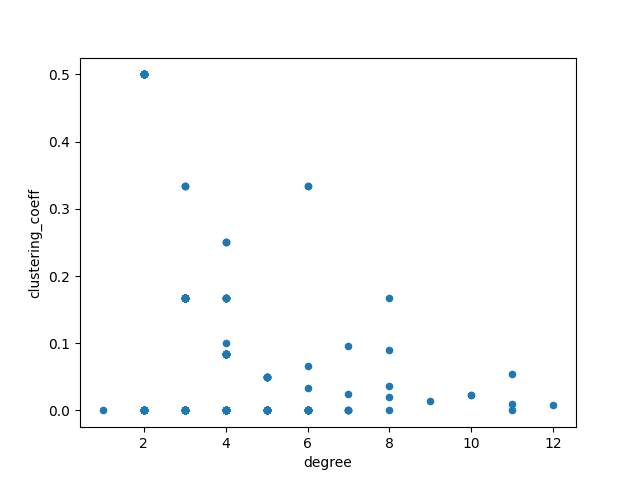

In [5]:
# Clustering
%matplotlib widget
df.plot(kind='scatter', x='degree' ,y='clustering_coeff')
plt.show()

In [73]:
# Cocitation and bibliography


In [74]:
# Communities
G2_freq_undir = G2_freq.to_undirected(reciprocal=False)
d_communities = nx.community.asyn_lpa_communities(G2_freq_undir,weight='weight')
# for c in d_communities:
#     print(list(c))